In [1]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,Dense
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint

In [3]:
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy.misc import imresize
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub
from keras.utils import np_utils
from keras.models import Sequential

In [4]:
melonoma_images = np.load('segmented_melanoma.npy')

In [5]:
melonoma_images[0].shape

(767, 1022, 3)

In [6]:
image = misc.imresize(melonoma_images[0],(256,128))

In [7]:
image.shape

(256, 128, 3)

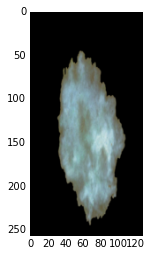

In [8]:
plt.imshow(image)

In [9]:
resized_melanoma_images = []
for i in range(len(melonoma_images)) :
    image = misc.imresize(melonoma_images[i],(256,128))
    resized_melanoma_images.append(image)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
np.save('resized_segmented_melanoma_256_128.npy', np.array(resized_melanoma_images))

In [11]:
other_images = np.load('segmented_others.npy')

In [12]:
resized_other_images = []
for i in range(len(other_images)) :
    image = misc.imresize(other_images[i],(256,128))
    resized_other_images.append(image)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
np.save('resized_segmented_others_256_128.npy', np.array(resized_other_images))

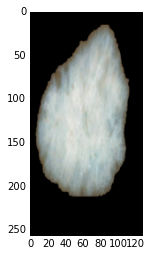

In [14]:
plt.imshow(resized_other_images[0])

In [15]:
labels = np.zeros(2000)

In [16]:
labels[0]

0.0

In [17]:
for i in range(374):
    labels[i] = 1

In [18]:
labels[2]

1.0

In [19]:
labels[374]

0.0

In [20]:
resized_other = np.array(resized_other_images)

In [21]:
resized_melanoma = np.array(resized_melanoma_images)

In [22]:
resized_melanoma.shape

(374, 256, 128, 3)

In [23]:
resized_other.shape

(1626, 256, 128, 3)

In [24]:
total_images = np.concatenate((resized_melanoma, resized_other) )

In [25]:
total_images.shape

(2000, 256, 128, 3)

In [26]:
np.save("total_images_256_128.npy", total_images)

In [27]:
train_indices = np.random.choice(2000,1500,replace = False)
print(sorted(train_indices))
train_images = []
train_labels = []

for i in train_indices:
    train_images.append(total_images[i])
    train_labels.append(labels[i])

test_indices = [x for x in range(2000) if x not in train_indices]
print(test_indices)
test_images = []
test_labels = []
for i in test_indices:
    test_images.append(total_images[i])
    test_labels.append(labels[i])


[0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 34, 35, 36, 37, 38, 39, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 67, 68, 69, 70, 72, 73, 74, 78, 79, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 118, 120, 121, 123, 125, 126, 127, 128, 129, 130, 131, 133, 134, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 155, 157, 158, 160, 162, 167, 169, 170, 171, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 185, 187, 188, 189, 190, 191, 193, 194, 197, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 212, 213, 214, 215, 216, 219, 220, 222, 223, 224, 226, 227, 228, 230, 231, 232, 234, 237, 238, 239, 240, 241, 243, 244, 245, 246, 248, 250, 251, 252, 253, 254, 255, 257, 258, 259, 261, 262, 263, 264, 265, 268, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282, 283, 284, 285, 289, 291, 293, 294, 

In [28]:
np.save('train_images_256_128.npy', np.array(train_images))

In [29]:
np.save('train_labels_256_128.npy', np.array(train_labels))

In [30]:
np.save('test_images_256_128.npy', np.array(test_images))

In [31]:
np.save('test_labels_256_128.npy', np.array(test_labels))

In [32]:
test_labels

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [4]:
x_train = np.load("train_images_256_128.npy")
y_train = np.load("train_labels_256_128.npy")
x_test = np.load("test_images_256_128.npy")
y_test = np.load("test_labels_256_128.npy")

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [6]:
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [7]:
y_train.shape

(1500,)

In [8]:
y_test.shape

(500,)

In [9]:
y_test[65]

1.0

In [10]:
#one hot encoding of target labels
#num_classes = 2
#y_train = np_utils.to_categorical(y_train,num_classes)
#y_test = np_utils.to_categorical(y_test,num_classes)

In [11]:
baseMapNum = 32
weight_decay = 1e-4

In [12]:
model = Sequential()
model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 128, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 256, 128, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 64, 32)       0         
__________

In [13]:
model.compile(loss='binary_crossentropy',
        optimizer="Adam",
        metrics=['accuracy'])

In [19]:
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('classification_lr_e2_bs8_after20.csv')
model_chekpoint = ModelCheckpoint("classification_lr_e2_bs8_after20.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [20]:
batch_size = 8
data_augmentation = False
epochs = 100

In [21]:
if data_augmentation :
    print("-------------Using Data augmentation------------")
     # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    datagen.fit(x_train)
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=20,verbose=1,validation_data=(x_test,y_test))
    
else :
    print("-----Not Using Data augmentation---------------")
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger,model_chekpoint])

-----Not Using Data augmentation---------------
Train on 1500 samples, validate on 500 samples
Epoch 1/100
1500/1500 [==============================] - 141s - loss: 2.9794 - acc: 0.8173 - val_loss: 3.2581 - val_acc: 0.8000
Epoch 2/100
1500/1500 [==============================] - 138s - loss: 2.9780 - acc: 0.8173 - val_loss: 3.2567 - val_acc: 0.8000
Epoch 3/100
1500/1500 [==============================] - 139s - loss: 2.9766 - acc: 0.8173 - val_loss: 3.2552 - val_acc: 0.8000
Epoch 4/100
1500/1500 [==============================] - 138s - loss: 2.9751 - acc: 0.8173 - val_loss: 3.2537 - val_acc: 0.8000
Epoch 5/100
1500/1500 [==============================] - 138s - loss: 2.9736 - acc: 0.8173 - val_loss: 3.2522 - val_acc: 0.8000
Epoch 6/100
1500/1500 [==============================] - 138s - loss: 2.9721 - acc: 0.8173 - val_loss: 3.2507 - val_acc: 0.8000
Epoch 7/100
1500/1500 [==============================] - 138s - loss: 2.9706 - acc: 0.8173 - val_loss: 3.2492 - val_acc: 0.8000
Epoch 8/1

KeyboardInterrupt: 